## COMP5625M Assessment 2 - Image Caption Generation [100 marks]

<div class="logos"><img src="./Comp5625M_logo.jpg" width="220px" align="right"></div>

The maximum marks for each part are shown in the section headers. The overall assessment carries a total of 100 marks.

This assessment is weighted 25% of the final grade for the module.

### Motivation

Through this assessment, you will:

> 1. Understand the principles of text pre-processing and vocabulary building.
> 2. Gain experience working with an image-to-text model.
> 3. Use and compare two text similarity metrics for evaluating an image-to-text model, and understand evaluation challenges.


### Setup and resources

Having a GPU will speed up the image feature extraction process. If you want to use a GPU, please refer to the module website for recommended working environments with GPUs.

Please implement the coursework using PyTorch and Python-based libraries, and refer to the notebooks and exercises provided.

This assessment will use a subset of the [COCO "Common Objects in Context" dataset](https://cocodataset.org/) for image caption generation. COCO contains 330K images of 80 object categories, and at least five textual reference captions per image. Our subset consists of nearly 5070 of these images, each with five or more different descriptions of the salient entities and activities, and we will refer to it as COCO_5070.

To download the data:

> 1. **Images and annotations**: download the zipped file provided in the link here as [``COMP5625M_data_assessment_2.zip``](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/EWWzE-_AIrlOkvOKxH4rjIgBF_eUx8KDJMPKM2eHwCE0dg?e=DdX62H).

``Info only:`` To understand more about the COCO dataset, you can look at the [download page](https://cocodataset.org/#download). We have already provided you with the "2017 Train/Val annotations (241MB)", but our image subset consists of fewer images than the original COCO dataset. **So, no need to download anything from here!**

> 2. **Image metadata**: as our set is a subset of the full COCO dataset, we have created a CSV file containing relevant metadata for our particular subset of images. You can also download it from Drive, "coco_subset_meta.csv", at the same link as 1.


### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, in .ipynb format. **Do not change the file name.**
> 2. The .html version of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) are displayed in the .html for marking.

**Final note:**

> **Please include everything you would like to be marked in this notebook, including figures. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the appropriate section.** Feel free to add as many code cells as you need under each section.

Your student username (for example, ```sc15jb```): mm22r2s

Your full name: Rahul Scaria

### Imports

Feel free to add to this section as needed.

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np
import re
from PIL import Image
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
import random

Detect which device (CPU/GPU) to use.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


The basic principle of our image-to-text model is as pictured in the diagram below, where an Encoder network encodes the input image as a feature vector by providing the outputs of the last convolutional layer of a pre-trained CNN (we use [ResNet50](https://arxiv.org/abs/1512.03385)). This pretrained network has been trained on the complete ImageNet dataset and is thus able to recognise common objects.

**(Hint)** You can alternatively use the COCO trained pretrained weights from [PyTorch](https://pytorch.org/vision/stable/models.html). One way to do this is use the "FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1" but use e.g., "resnet_model = model.backbone.body". Alternatively, you can use the checkpoint from your previous coursework where you finetuned to COCO dataset.

These features are then fed into a Decoder network along with the reference captions. As the image feature dimensions are large and sparse, the Decoder network includes a linear layer which downsizes them, followed by *a batch normalisation layer* to speed up training. Those resulting features, as well as the reference text captions, are then passed into a recurrent network (we will use **RNN** in this assessment).

The reference captions used to compute loss are represented as numerical vectors via an **embedding layer** whose weights are learned during training.

<!-- ![Encoder Decoder](comp5625M_figure.jpg) -->


<div>
<center><img src="comp5625M_figure_imageCaption.jpg" width="1000"/></center>
</div>


The Encoder-Decoder network could be coupled and trained end-to-end, without saving features to disk; however, this requires iterating through the entire image training set during training. We can make the **training more efficient by decoupling the networks**. Thus, we will:

> First extract the feature representations of the images from the Encoder

> Save these features (Part 1) such that during the training of the Decoder (Part 3), we only need to iterate over the image feature data and the reference captions.

**Hint**
Try commenting out the feature extraction part once you have saved the embeddings. This way if you have to re-run the entire codes for some reason then you can only load these features.


### Overview

> 1. Extracting image features
> 2. Text preparation of training and validation data
> 3. Training the decoder
> 4. Generating predictions on test data
> 5. Caption evaluation via BLEU score
> 6. Caption evaluation via Cosine similarity
> 7. Comparing BLEU and Cosine similarity


## 1 Extracting image features [11 marks]

> 1.1 Design a encoder layer with pretrained ResNet50 (4 marks)

> 1.2 Image feature extraction step (7 marks)

#### 1.1 Design a encoder layer with pretrained ResNet50 (4 marks)

> Read through the template EncoderCNN class below and complete the class.

> You are expected to use ResNet50 pretrained on imageNet provided in the Pytorch library (torchvision.models)


In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-50 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        # Your code here!
        self.resnet = models.resnet50(pretrained = True)

        # TO COMPLETE
        # keep all layers of the pretrained net except the last layers of fully-connected ones (you are permitted to take other layers too but this can affect your accuracy!)
        self.resnet=torch.nn.Sequential(*list(self.resnet.children())[:-1])


    def forward(self, images):
        """Extract feature vectors from input images."""
        images = self.resnet(images)

        # TO COMPLETE
        # remember no gradients are needed
        images=images.view(images.size(0),-1)
        return images




In [ ]:
# instantiate encoder and put into evaluation mode.
# Your code here!
encoder = EncoderCNN()
#for param in encoder.parameters():
#    print(param.shape)
encoder.eval()

C:\Users\rahul\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rahul\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

#### 1.2 Image feature extraction step (7 marks)

Pass the images through the ```Encoder``` model, saving the resulting features for each image. You may like to use a ```Dataset``` and ```DataLoader``` to load the data in batches for faster processing, or you may choose to simply read in one image at a time from disk without any loaders.

Note that as this is a forward pass only, no gradients are needed. You will need to be able to match each image ID (the image name without file extension) with its features later, so we suggest either saving a dictionary of image ID: image features, or keeping a separate ordered list of image IDs.

Use this ImageNet transform provided.

In [ ]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

In [ ]:
# Get unique images from the csv for extracting features - helper code
imageList = pd.read_csv("D:\Downloads\coco_subset_meta.csv")
imageList['file_name']
len(imageList.id.unique())

imagesUnique = sorted(imageList['file_name'].unique())
print(len(imagesUnique))

df_unique_files =  pd.DataFrame.from_dict(imagesUnique)

df_unique_files.columns = ['file_name']
df_unique_files

5068


,file_name
0,000000000009.jpg
1,000000000025.jpg
2,000000000030.jpg
3,000000000034.jpg
4,000000000036.jpg
...,...
5063,000000581906.jpg
5064,000000581909.jpg
5065,000000581913.jpg
5066,000000581921.jpg


In [ ]:
# Define a class COCOImagesDataset(Dataset) function that takes the
# image file names and reads the image and apply transform to it
# ---> your code here! we have provided you a sketch

IMAGE_DIR = "D:/Downloads/coco/images/"

class COCOImagesDataset(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        # --> your code here!
        self.transform = transform


    def __getitem__(self, index):
        filename = self.df.iloc[index]['file_name']

        # --> your code here!
        im = Image.open(IMAGE_DIR+filename).convert('RGB')
        #im = plt.imread()
        image = self.transform(im)



        return image, filename

    def __len__(self):
        return len(self.df)


In [ ]:
# Use Dataloader to use the unique files using the class COCOImagesDataset
# make sure that shuffle is False as we are not aiming to retrain in this exercise
# Your code here-->

coco_images_dataset=COCOImagesDataset(df_unique_files,transform=data_transform)
coco_images_dataset
dataloader=DataLoader(coco_images_dataset,batch_size=32,shuffle=True)
dataloader


In [ ]:
# Apply encoder to extract featues and save them (e.g., you can save it using image_ids)
# Hint - make sure to save your features after running this - you can use torch.save to do this

features_map = dict()
from tqdm.notebook import tqdm
from PIL import Image

with torch.no_grad():
# ---> Your code here!
    for images, file_names in tqdm(dataloader):
        features_batch = net(images)
        for i in range(images.size(0)):
            features_map[file_names[i]] = features_batch[i]

torch.save(features_map, 'features_map.pth')




  0%|          | 0/159 [00:00<?, ?it/s]

## 2 Text preparation [23 marks]

> 2.1 Build the caption dataset (3 Marks)

> 2.2 Clean the captions (3 marks)

> 2.3 Split the data (3 marks)

> 2.4 Building the vocabulary (10 marks)

> 2.5 Prepare dataset using dataloader (4 marks)


#### 2.1 Build the caption dataset (3 Marks)

All our selected COCO_5029 images are from the official 2017 train set.

The ```coco_subset_meta.csv``` file includes the image filenames and unique IDs of all the images in our subset. The ```id``` column corresponds to each unique image ID.

The COCO dataset includes many different types of annotations: bounding boxes, keypoints, reference captions, and more. We are interested in the captioning labels. Open ```captions_train2017.json``` from the zip file downloaded from the COCO website. You are welcome to come up with your own way of doing it, but we recommend using the ```json``` package to initially inspect the data, then the ```pandas``` package to look at the annotations (if you read in the file as ```data```, then you can access the annotations dictionary as ```data['annotations']```).

Use ```coco_subset_meta.csv``` to cross-reference with the annotations from ```captions_train2017.json``` to get all the reference captions for each image in COCO_5029.

For example, you may end up with data looking like this (this is a ```pandas``` DataFrame, but it could also be several lists, or some other data structure/s):

<img src="caption_image_ids.png" alt="images matched to caption" width="700"/>

In [ ]:
import json

# loading captions for training
with open("D:/Downloads/coco/annotations2017/captions_train2017.json", 'r') as json_file:
    data = json.load(json_file)

df = pd.DataFrame.from_dict(data["annotations"])
#df = df.sort_values(by='image_id', ascending = True)
df

,image_id,id,caption
0,203564,37,A bicycle replica with a clock as the front wh...
1,322141,49,A room with blue walls and a white sink and door.
2,16977,89,A car that seems to be parked illegally behind...
3,106140,98,A large passenger airplane flying through the ...
4,106140,101,There is a GOL plane taking off in a partly cl...
...,...,...,...
591748,133071,829655,a slice of bread is covered with a sour cream ...
591749,410182,829658,A long plate hold some fries with some sliders...
591750,180285,829665,Two women sit and pose with stuffed animals.
591751,133071,829693,White Plate with a lot of guacamole and an ext...


In [ ]:
# Hint: get the filename matching id from coco_subset_meta.csv - make sure that for each id you add image filename
coco_subset = pd.read_csv('D:/Downloads/coco_subset_meta.csv')
# --> your code here! - name the new dataframe as "new_file"

# Create a dictionary mapping image IDs to filenames
id_to_filename = {row['id']: row['file_name'] for i, row in coco_subset.iterrows()}


new_file = df.copy()

# Add the filename column to df
new_file['file_name'] = new_file['image_id'].apply(lambda x: id_to_filename.get(x, ''))

# Create a new DataFrame with non-empty filenames
new_file = new_file[new_file['file_name'] != ''].reset_index(drop=True)
new_file




,image_id,id,caption,file_name
0,57429,2049,An airplane with its landing wheels out landing.,000000057429.jpg
1,57429,2139,A plane that is taking off at an airport,000000057429.jpg
2,57429,2946,A man takes a picture of an airplane taking off.,000000057429.jpg
3,410627,2961,The young man is stirring his pot of food with...,000000410627.jpg
4,554037,5010,"a counter with vegetables, knife and cutting b...",000000554037.jpg
...,...,...,...,...
25344,180285,829395,A couple of women with some stuffed animals.,000000180285.jpg
25345,180285,829607,Fans pose with stuffed animals at an ice rink.,000000180285.jpg
25346,180285,829636,"Two women smiling together, one holds a stuffe...",000000180285.jpg
25347,180285,829653,Two women smile for the camea while posing iwt...,000000180285.jpg


In [ ]:
sum(new_file['file_name']=='')

0

#### 2.2 Clean the captions (3 marks)

Create a cleaned version of each caption. If using dataframes, we suggest saving the cleaned captions in a new column; otherwise, if you are storing your data in some other way, create data structures as needed.

**A cleaned caption should be all lowercase, and consist of only alphabet characters.**

Print out 10 original captions next to their cleaned versions to facilitate marking.


<img src="cleancaptions.png" alt="images matched to caption" width="700"/>

In [ ]:
new_file['clean_caption'] = "" # add a new column to the dataframe for the cleaned captions

def clean_caption(caption):

    # Remove spaces in the beginning and at the end
    # Convert to lower case
    # Replace all non-alphabet characters with space
    # Replace all continuous spaces with a single space
    caption = caption.strip().lower()
    caption = re.sub('[^a-z]+', ' ', caption)
    caption = re.sub(' +', ' ', caption)
    return caption

def gen_clean_captions_df(df):

    df["clean_caption"] = df["caption"].apply(clean_caption)
    return df


In [ ]:
# clean and print 10 of these
new_file = gen_clean_captions_df(new_file)
new_file

,image_id,id,caption,file_name,clean_caption
0,57429,2049,An airplane with its landing wheels out landing.,000000057429.jpg,an airplane with its landing wheels out landing
1,57429,2139,A plane that is taking off at an airport,000000057429.jpg,a plane that is taking off at an airport
2,57429,2946,A man takes a picture of an airplane taking off.,000000057429.jpg,a man takes a picture of an airplane taking off
3,410627,2961,The young man is stirring his pot of food with...,000000410627.jpg,the young man is stirring his pot of food with...
4,554037,5010,"a counter with vegetables, knife and cutting b...",000000554037.jpg,a counter with vegetables knife and cutting bo...
...,...,...,...,...,...
25344,180285,829395,A couple of women with some stuffed animals.,000000180285.jpg,a couple of women with some stuffed animals
25345,180285,829607,Fans pose with stuffed animals at an ice rink.,000000180285.jpg,fans pose with stuffed animals at an ice rink
25346,180285,829636,"Two women smiling together, one holds a stuffe...",000000180285.jpg,two women smiling together one holds a stuffed...
25347,180285,829653,Two women smile for the camea while posing iwt...,000000180285.jpg,two women smile for the camea while posing iwt...


#### 2.3  Split the data (3 marks)

Split the data 70/10/20% into train/validation/test sets. **Be sure that each unique image (and all corresponding captions) only appear in a single set.**

We provide the function below which, given a list of unique image IDs and a 3-split ratio, shuffles and returns  a split of the image IDs.

If using a dataframe, ```df['image_id'].unique()``` will return the list of unique image IDs.

In [ ]:
import random
import math

def split_ids(image_id_list, train=.7, valid=0.1, test=0.2):
    """
    Args:
        image_id_list (int list): list of unique image ids
        train (float): train split size (between 0 - 1)
        valid (float): valid split size (between 0 - 1)
        test (float): test split size (between 0 - 1)
    """
    list_copy = image_id_list.copy()
    random.shuffle(list_copy)

    train_size = math.floor(len(list_copy) * train)
    valid_size = math.floor(len(list_copy) * valid)

    return list_copy[:train_size], list_copy[train_size:(train_size + valid_size)], list_copy[(train_size + valid_size):]

In [ ]:
unique_ids = new_file['image_id'].unique()

In [ ]:
train_ids, validation_ids, test_ids = split_ids(image_id_list = unique_ids)

In [ ]:
print(len(validation_ids))

506


In [ ]:
test_ids

array([180357,  24637, 246089, ..., 295419, 459218, 106614], dtype=int64)

In [ ]:

#new_file['image_id'] = new_file['image_id'].astype(int)

#train_set = [data for data in new_file if data['image_id'] in str(train_ids)]
train_set = new_file[new_file['image_id'].isin(train_ids)]
validation_set = new_file[new_file['image_id'].isin(validation_ids)]
test_set = new_file[new_file['image_id'].isin(test_ids)]


In [ ]:
train_set

,image_id,id,caption,file_name,clean_caption
3,410627,2961,The young man is stirring his pot of food with...,000000410627.jpg,the young man is stirring his pot of food with...
4,554037,5010,"a counter with vegetables, knife and cutting b...",000000554037.jpg,a counter with vegetables knife and cutting bo...
5,554037,5433,"asparragus, lemons and a bowl of rice on a cou...",000000554037.jpg,asparragus lemons and a bowl of rice on a coun...
7,143370,5786,A bathroom with a poster of an ugly face above...,000000143370.jpg,a bathroom with a poster of an ugly face above...
8,554037,6108,"The preparation of salmon, asparagus and lemons.",000000554037.jpg,the preparation of salmon asparagus and lemons
...,...,...,...,...,...
25344,180285,829395,A couple of women with some stuffed animals.,000000180285.jpg,a couple of women with some stuffed animals
25345,180285,829607,Fans pose with stuffed animals at an ice rink.,000000180285.jpg,fans pose with stuffed animals at an ice rink
25346,180285,829636,"Two women smiling together, one holds a stuffe...",000000180285.jpg,two women smiling together one holds a stuffed...
25347,180285,829653,Two women smile for the camea while posing iwt...,000000180285.jpg,two women smile for the camea while posing iwt...


#### 2.4 Building the vocabulary (10 marks)

The vocabulary consists of all the possible words which can be used - both as input into the model, and as output predictions, and we will build it using the cleaned words found in the reference captions from the training set. In the vocabulary each unique word is mapped to a unique integer (a Python ```dictionary``` object).

A ```Vocabulary``` object is provided for you below to use.

In [ ]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            # this will convert each word to index and index to word as you saw in the tutorials
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)


Collect all words from the cleaned captions in the **training and validation sets**, ignoring any words which appear 3 times or less; this should leave you with roughly 2200 words (plus or minus is fine). As the vocabulary size affects the embedding layer dimensions, it is better not to add the very infrequently used words to the vocabulary.

Create an instance of the ```Vocabulary()``` object and add all your words to it.

In [ ]:
# [Hint] building a vocab function such with frequent words e.g., setting MIN_FREQUENCY = 3
MIN_FREQUENCY = 3

def build_vocab(df_ids, new_file):
    """
    Parses training set token file captions and builds a Vocabulary object and dataframe for
    the image and caption data

    Returns:
        vocab (Vocabulary): Vocabulary object containing all words appearing more than min_frequency
    """
    word_mapping = Counter()

    # for index in df.index:
    for index, id in enumerate(df_ids):
        caption = str(new_file.loc[new_file['image_id']==id]['clean_caption'].values)
        caption = clean_series(caption)
        for word in caption.split():
            # also get rid of numbers, symbols etc.
            if word in word_mapping:
                word_mapping[word] += 1
            else:
                word_mapping[word] = 1
    # create a vocab instance
    vocab = Vocabulary()

    # add the words to the vocabulary
    for word in word_mapping:
        # Ignore infrequent words to reduce the embedding size
        # --> Your code here!
        if word_mapping[word] > MIN_FREQUENCY:
            vocab.add_word(word)

    return vocab


In [ ]:
    def clean_series(s):
        # Remove unwanted characters
        s = s.strip("[]")  # Remove square brackets
        s = s.replace("\n", "")  # Remove newline characters
        s = s.replace("'", "")  # Remove single quotes
        s = re.sub(r'\s+', ' ', s.strip()) # Replace all continuous spaces with a single space
        return s

In [ ]:
# build your vocabulary for train, valid and test sets
# ---> your code here!


In [ ]:
training_vocab = build_vocab(train_ids, new_file)
validation_vocab = build_vocab(validation_ids, new_file)
test_vocab = build_vocab(test_ids, new_file)


In [ ]:
len(test_vocab)

1139

In [ ]:
combined_ids = np.concatenate((train_ids,validation_ids))
combined_vocab = build_vocab(combined_ids, new_file)

In [ ]:
len(combined_vocab)

2411

In [ ]:
len(test_vocab)

1142

In [ ]:
len(training_vocab)

2254

In [ ]:
len(set(features_map.keys()))

5068

#### 2.5 Prepare dataset using dataloader (4 marks)

Create a PyTorch ```Dataset``` class and a corresponding ```DataLoader``` for the inputs to the decoder. Create three sets: one each for training, validation, and test. Set ```shuffle=True``` for the training set DataLoader.

The ```Dataset``` function ```__getitem__(self, index)``` should return three Tensors:

>1. A Tensor of image features, dimension (1, 2048).
>2. A Tensor of integer word ids representing the reference caption; use your ```Vocabulary``` object to convert each word in the caption to a word ID. Be sure to add the word ID for the ```<end>``` token at the end of each caption, then fill in the the rest of the caption with the ```<pad>``` token so that each caption has uniform lenth (max sequence length) of **47**.
>3. A Tensor of integers representing the true lengths of every caption in the batch (include the ```<end>``` token in the count).


Note that as each unique image has five or more (say, ```n```) reference captions, each image feature will appear ```n``` times, once in each unique (feature, caption) pair.

In [ ]:
MAX_SEQ_LEN = 47

class COCO_Features(Dataset):
    """ COCO subset custom dataset, compatible with torch.utils.data.DataLoader. """

    def __init__(self, df, features, vocab):
        """
        Args:
            df: (dataframe or some other data structure/s you may prefer to use)
            features: image features
            vocab: vocabulary wrapper

        """
        self.df = df
        self.features = features
        self.vocab = vocab

        # TO COMPLETE


    def __getitem__(self, index):
        """ Returns one data tuple (feature [1, 2048], target caption of word IDs [1, 47], and integer true caption length) """

        # TO COMPLETE
        # get the image feature tensor
        image_id = self.df.iloc[index]['file_name']
        feature = torch.tensor(self.features[image_id], dtype=torch.float32)

        # get the reference caption and convert each word to its ID using the vocabulary object
        caption = self.df.iloc[index]['clean_caption'].split()
        caption = [self.vocab(word) for word in caption] + [self.vocab('<end>')]
        true_length = len(caption)
        while len(caption) < MAX_SEQ_LEN:
            caption.append(self.vocab('<pad>'))
        caption_tensor = torch.tensor(caption, dtype=torch.long)

        return feature.unsqueeze(0), caption_tensor.unsqueeze(0), torch.tensor(true_length, dtype=torch.long)



    def __len__(self):
        return len(self.df)


In [ ]:
def caption_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple (image, caption).
            - image: torch tensor of shape (3, 224, 224).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 224, 224).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # --> Your code here
    # Sort a data list by caption length from longest to shortest.
    sorted_data = sorted(data, key=lambda x: x[2], reverse=True)


    # Separate images and captions into separate lists
    images, captions, lengths = zip(*sorted_data)

    # merge images (from tuple of 3D tensor to 4D tensor).
    # if using features, 2D tensor to 3D tensor. (batch_size, 256)

    # Merge images (from tuple of 3D tensor to 4D tensor)
    images = torch.cat(images, dim=0)

    # merge captions (from tuple of 1D tensor to 2D tensor).
    captions = torch.cat(captions, dim=0)

    # Get the lengths of each caption before padding
    lengths = torch.tensor(lengths, dtype=torch.long)


    return images, captions, lengths


In [ ]:
dataset_train = COCO_Features(
    df=train_set,
    vocab=combined_vocab,
    features=features_map,
)

#  your dataloader here (make shuffle true as you will be training RNN)
# --> your code here!
batchSize= 16

# Creating the data loaders
train_loader = DataLoader(dataset_train, batch_size=batchSize, shuffle=True,collate_fn=caption_collate_fn)

# Do the same as above for your validation set
# ---> your code here!
dataset_val = COCO_Features(
    df=validation_set,
    vocab=combined_vocab,
    features=features_map,
)

# Creating the data loaders
validation_loader = DataLoader(dataset_val, batch_size=batchSize, shuffle=False,collate_fn=caption_collate_fn)




Load one batch of the training set and print out the shape of each returned Tensor.

In [ ]:

features, captions, lengths = next(iter(train_loader))
print("Features shape:", features.shape)
print("Captions shape:", captions.shape)
print("Lengths shape:", lengths.shape)




Features shape: torch.Size([16, 2048])
Captions shape: torch.Size([16, 47])
Lengths shape: torch.Size([16])


C:\Users\rahul\AppData\Local\Temp\ipykernel_15900\1139304950.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[image_id], dtype=torch.float32)


## 3 Train DecoderRNN [20 marks]

> 3.1 Design RNN-based decoder (10 marks)

> 3.2 Train your model with precomputed features (10 Marks)

#### 3.1 Design a RNN-based decoder (10 marks)

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```RNN``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).


In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        # we want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last convolutional layer (flattened to dimensions after AdaptiveAvgPool2d that may give you => 1 x 1 x 2048, other layers are also accepted but this will affect your accuracy!)
        # into a Linear layer to resize
        # your code
        self.resize = nn.Linear(2048, embed_size)

        # batch normalisation helps to speed up training
        # your code
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

        # your code for embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size)

        # your code for RNN
        self.rnn = nn.LSTM(input_size = embed_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        # self.linear: linear layer with input: hidden layer, output: vocab size
        # --> your code
        self.linear = nn.Linear(hidden_size, vocab_size)

        self.max_seq_length = max_seq_length


    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        im_features = self.resize(features)
        im_features = self.bn(im_features)

        # compute your feature embeddings
        # your code

        inputs = torch.cat((im_features.unsqueeze(1), embeddings), 1)

        # pack_padded_sequence returns a PackedSequence object, which contains two items:
        # the packed data (data cut off at its true length and flattened into one list), and
        # the batch_sizes, or the number of elements at each sequence step in the batch.
        # For instance, given data [a, b, c] and [x] the PackedSequence would contain data
        # [a, x, b, c] with batch_sizes=[2,1,1].

        # your code [hint: use pack_padded_sequence]
        packed_sequence = pack_padded_sequence(inputs, lengths, batch_first=True)

        # RNN layer
        hiddens, _ = self.rnn(packed_sequence)

        outputs = self.linear(hiddens[0]) #hint: use a hidden layers in parenthesis
        return outputs


    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []

        inputs = self.bn(self.resize(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))   # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)               # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)              # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)       # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids


In [ ]:
# instantiate decoder
# your code here!
sample_decoder = DecoderRNN(vocab_size=1000, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47)
sample_decoder

DecoderRNN(
  (resize): Linear(in_features=2048, out_features=256, bias=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (embed): Embedding(1000, 256)
  (rnn): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=1000, bias=True)
)

#### 3.2 Train your model with precomputed features (10 marks)

Train the decoder by passing the features, reference captions, and targets to the decoder, then computing loss based on the outputs and the targets. Note that when passing the targets and model outputs to the loss function, the targets will also need to be formatted using ```pack_padded_sequence()```.

We recommend a batch size of around 64 (though feel free to adjust as necessary for your hardware).

**We strongly recommend saving a checkpoint of your trained model after training so you don't need to re-train multiple times.**

Display a graph of training and validation loss over epochs to justify your stopping point.

In [ ]:
num_epochs = 4

embed_size = 256
hidden_size = 512
num_layers = 2

decoder = DecoderRNN(vocab_size=len(combined_vocab), embed_size=embed_size, hidden_size=hidden_size, num_layers=num_layers)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(decoder.parameters(), lr=0.001)

train_losses = []
validation_losses = []
best_validation_loss = float('inf')
best_decoder_state = None
epoch_no_improve = 0

# Train the decoder
for epoch in range(num_epochs):
    decoder.train()
    train_loss  = 0.0
    for i, (features, captions, lengths) in enumerate(train_loader):
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Forward pass
        outputs = decoder(features, captions, lengths)

        # Compute loss
        loss = criterion(outputs, targets)
        train_loss += loss.item()

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print status every 500 batches
        if i % 500 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_loader)}], Train Loss: {loss.item():.4f}")


    # Validation loop
    decoder.eval()
    validation_loss = 0
    validation_targets = []
    validation_preds = []
    with torch.no_grad():
        for i, (features, captions, lengths) in enumerate(validation_loader):

            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

            # Forward pass
            outputs = decoder(features, captions, lengths)

            # Computing loss
            loss = criterion(outputs, targets)
            validation_loss += loss.item()

            # Computing accuracy
            _, predicted = torch.max(outputs, dim=1)
            predicted = predicted.cpu().tolist()
            targets = targets.cpu().tolist()
            validation_targets.extend(targets)
            validation_preds.extend(predicted)

    # Computing mean losses
    train_loss /= len(train_loader)
    validation_loss /= len(validation_loader)
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)

    # Print epoch summary
    print(f"Epoch [{epoch}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}")

    #Stopping iteration if there's no improvement
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        best_decoder_state = decoder.state_dict()
        epoch_no_improve = 0
    else :
        epoch_no_improve+=1
        if epoch_no_improve == 3:
            print("Stopping training, as validation loss hasn't improved in the last 3 epochs")
            break

# Saving the best decoder state
torch.save(best_decoder_state, "decoder.pth")

C:\Users\rahul\AppData\Local\Temp\ipykernel_15900\1139304950.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[image_id], dtype=torch.float32)


Epoch [0/4], Step [0/1109], Train Loss: 7.7828
Epoch [0/4], Step [500/1109], Train Loss: 3.6152
Epoch [0/4], Step [1000/1109], Train Loss: 3.3878
Epoch [0/4], Train Loss: 3.8333, Validation Loss: 3.3119
Epoch [1/4], Step [0/1109], Train Loss: 2.8870
Epoch [1/4], Step [500/1109], Train Loss: 2.6430
Epoch [1/4], Step [1000/1109], Train Loss: 2.5995
Epoch [1/4], Train Loss: 2.9574, Validation Loss: 3.0278
Epoch [2/4], Step [0/1109], Train Loss: 2.7088
Epoch [2/4], Step [500/1109], Train Loss: 2.3940
Epoch [2/4], Step [1000/1109], Train Loss: 2.6431
Epoch [2/4], Train Loss: 2.5777, Validation Loss: 2.9317
Epoch [3/4], Step [0/1109], Train Loss: 2.3783
Epoch [3/4], Step [500/1109], Train Loss: 1.9348
Epoch [3/4], Step [1000/1109], Train Loss: 1.7941
Epoch [3/4], Train Loss: 2.2835, Validation Loss: 2.9314


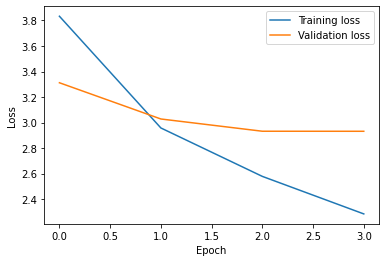

In [ ]:
epochs = range(len(train_losses))
plt.plot(epochs, train_losses, label="Training loss")
plt.plot(epochs, validation_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 4 Generate predictions on test data [8 marks]

Display 5 sample test images containing different objects, along with your model’s generated captions and all the reference captions for each.

> Remember that everything **displayed** in the submitted notebook and .html file will be marked, so be sure to run all relevant cells.

In [ ]:
# Get unique file names in test set

unique_filenames = test_set['file_name'].unique()

# Selecting 5 at random from unique_filenames

random_filenames = random.sample(list(unique_filenames), 5)

In [ ]:
random_filenames

['000000350340.jpg',
 '000000396421.jpg',
 '000000450749.jpg',
 '000000198653.jpg',
 '000000196798.jpg']

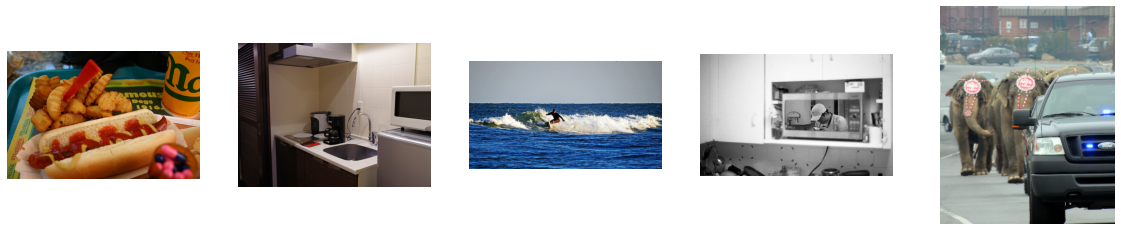

In [ ]:
test_images = []
for filepath in random_filenames:
    full_path = IMAGE_DIR + filepath
    img = Image.open(full_path).convert('RGB')
    test_images.append(img)

fig,axes = plt.subplots(1,5, figsize=(20,4))
for i, image in enumerate(test_images):
    axes[i].imshow(image)
    axes[i].axis('off')
plt.show()

In [ ]:
def generate_image(filename):
    full_path = IMAGE_DIR + filename
    img = Image.open(full_path).convert('RGB')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
def generate_predictions(features, decoder):

    generated_caption = []

    with torch.no_grad():
        # Using the caption function of the decoder
        sample_ids = decoder.sample(features)
        # Converting tokens to words
        sampled_caption = []
        for word_id in sample_ids[0]:
            word = combined_vocab.idx2word[word_id.item()]
            sampled_caption.append(word)
            if word == '<end>':
                break
        caption = ' '.join(sampled_caption[1:-1])
        generated_caption.append(caption)

    return generated_caption

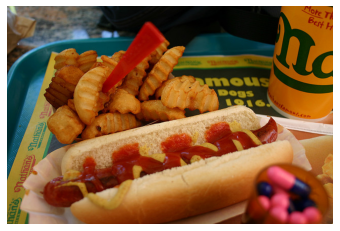

['person is holding a hot dog with ketchup mustard and a bowl of food']
['A tray with a hot dog next to fries and a drink.', 'A hot dog and french fries are on a plate.', 'A meal tray with a hot dog and fries.', 'The hotdog with mustard and ketchup has a side of french fries.', 'A hot dog and fries are served on a tray.']


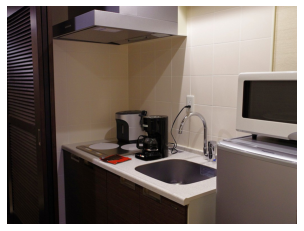

['kitchen with a stove sink and microwave oven']
['a kitchen with a sink a coffee maker and a microwave', 'Sink set in corner by microwave and small refrigerator ', 'A very small oven, sink, and refrigerator in a room.', 'A small kitchen with a sink, coffee maker and a stove.', 'The tiny kitchen has a small refrigerator and a microwave.']


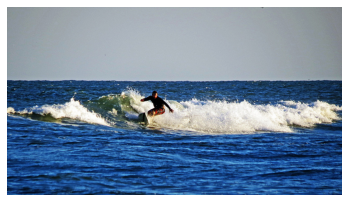

['surfer is surfing on a wave in the ocean']
['A man riding a wave back to the shore', 'A man riding a surfboard on a wave.', 'An small ocean wave with a surfboard rider', 'A surfer is catching a wave in the blue water.', 'a person riding a surf board on a small wave']


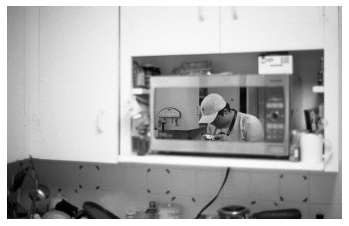

['small bathroom with a sink and a sink']
['a room that has a microwave in it', 'A mans reflection can be seen in a microwave door.', 'There is a reflection of a man wearing a hat.', 'The reflection of a man is in the door of the microwave. ', 'A man works in a black and white kitchen.']


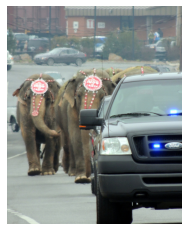

['truck is parked on the street next to a street']
['A parade of circus elephants lead by an SUV.', 'A herd of elephants take their place in traffic.', 'a herd of circus elephants walking down a road behind a car', 'A car is followed by a group of elephants in a street. ', 'A police escort leading the way as several circus elephants travel along the street.']


In [ ]:
# Generating captions for test images
for i,image in enumerate(random_filenames):

    features = features_map[image]

    features_tensor = features.unsqueeze(0)

    # Generating predicted captions
    generated_caption = generate_predictions(features_tensor, decoder)

    image_id = image.split('.')[0].lstrip('0')

    # Getting reference captions
    reference_captions = test_set.query('image_id== '+image_id)['caption'].values.tolist()

    generate_image(image)
    print(generated_caption)
    print(reference_captions)

## 5 Caption evaluation using BLEU score [10 marks]

There are different methods for measuring the performance of image to text models. We will evaluate our model by measuring the text similarity between the generated caption and the reference captions, using two commonly used methods. Ther first method is known as *Bilingual Evaluation Understudy (BLEU)*.

> 5.1 Average BLEU score on all data (5 marks)

> 5.2 Examplaire high and low score BLEU score samples (5 marks, at least two)

####  5.1 Average BLEU score on all data (5 marks)


One common way of comparing a generated text to a reference text is using BLEU. This article gives a good intuition to how the BLEU score is computed: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/, and you may find an implementation online to use. One option is the NLTK implementation `nltk.translate.bleu_score` here: https://www.nltk.org/api/nltk.translate.bleu_score.html


> **Tip:** BLEU scores can be weighted by ith-gram. Check that your scores make sense; and feel free to use a weighting that best matches the data. We will not be looking for specific score ranges; rather we will check that the scores are reasonable and meaningful given the captions.

Write the code to evaluate the trained model on the complete test set and calculate the BLEU score using the predictions, compared against all five references captions.

Display a histogram of the distribution of scores over the test set.

In [ ]:
test_dataset = COCO_Features(
    df = test_set,
    vocab = train_val_vocab,
    features = features_map
)

test_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle = True, collate_fn = caption_collate_fn)

In [ ]:
# TO COMPLETE
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
stats = pd.DataFrame(columns=['ref','preds','bleu','cos_sim'])#dict()

# --> Your code here!
smoothing_fn = SmoothingFunction().method1

image_filenames = []
predictions = []
captions = []
bleu = []
stats = []

decoder.eval()

for index, row in test_set.iterrows():
    image_filename = row['file_name']
    caption_list = row['clean_caption'].split()

    if image_filename not in image_filenames:
        image_filenames.append(image_filename)
        captions.append([caption_list])
    else:
        idx = image_filenames.index(image_filename)
        captions[idx].append(caption_list)


for i, image_filename in enumerate(image_filenames):

    features = features_map[image_filename]
    features_tensor = features.unsqueeze(0)

    with torch.no_grad():
        generated_caption = convert_to_words(decoder.sample(features_tensor)[0])
        predictions.append(generated_caption)

    bleu = sentence_bleu(captions[i], generated_caption, smoothing_function = smoothing_fn,
                        auto_reweigh = True, weights=[1/4]*4)
    #print(bleu)

    image_id = image_filename.split('.')[0].lstrip('0')

    stats.append({'image_id': image_id, 'ref': captions[i], 'pred': predictions[i], 'bleu': bleu})

stats = pd.DataFrame(stats)


In [ ]:
len(captions)

1015

In [ ]:
def convert_to_words(id_seq):
    ind = 0
    while ind < 47 and id_seq[ind].item() not in [0, 2]:
        ind = ind + 1
    return [combined_vocab.idx2word[id.item()] for id in id_seq][: ind]

Average BLEU score: 0.16297789643479207


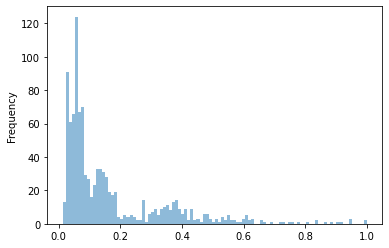

In [ ]:
print("Average BLEU score:", stats['bleu'].mean())
ax = stats['bleu'].plot.hist(bins=100, alpha=0.5)

#### 5.2 Examplaire high and low score BLEU score samples (5 marks)

Find one sample with high BLEU score and one with a low score, and display the model's predicted sentences, the BLEU scores, and the 5 reference captions.

In [ ]:
# TO COMPLETE

Lowest bleu score = 0.01239892724105193


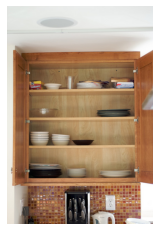

Reference captions:
a kitchen cupboard full of a variety of dishes
a cabinet filled with black and white dishes and bowls
a cupboard with the doors open full of plates and bowls
a kitchen cupboard above a counter holding dishes
wooden cupboards in a kitchen contain plates and small bowls
Predicted caption:
a kitchen with a stove and a stove and a table with a stove and a table with a table and a table with a table and a table with a table and a table with a table and a glass of wine


In [ ]:
lowest_bleu_row = stats.iloc[stats['bleu'].idxmin()]
lowest_bleu_row

# Reference captions

reference_captions = stats[stats['image_id'] == lowest_bleu_row['image_id']]['ref'].item()
reference_captions

print('Lowest bleu score =', lowest_bleu_row['bleu'])

filename = new_file[new_file['image_id']==lowest_bleu_row['image_id']].iloc[0]['file_name']
generate_image(filename)

print('Reference captions:')
for caption in reference_captions:
    print(' '.join(caption))
print('Predicted caption:')
print(' '.join(lowest_bleu_row['pred']))

Highest bleu score = 1.0


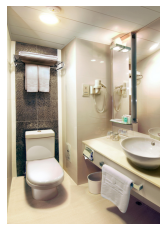

Reference captions:
a bathroom with a toilet sitting next to a sink
a bathroom with a sink and a mirror
a nice clean bathroom with a large sink
a clean well lit and fully stocked marble hotel bathroom
a small white bathroom with a toilet and a sink
Predicted caption:
a bathroom with a toilet and a sink


In [ ]:
highest_bleu_row = stats.iloc[stats['bleu'].idxmax()]
highest_bleu_row

# Reference captions

reference_captions = stats[stats['image_id'] == highest_bleu_row['image_id']]['ref'].item()
reference_captions

print('Highest bleu score =', highest_bleu_row['bleu'])

filename = new_file[new_file['image_id']==highest_bleu_row['image_id']].iloc[0]['file_name']
generate_image(filename)

print('Reference captions:')
for caption in reference_captions:
    print(' '.join(caption))
print('Predicted caption:')
print(' '.join(highest_bleu_row['pred']))

## 6 Caption evaluation using cosine similarity [12 marks]

> 6.1 Cosine similarity (6 marks)

> 6.2 Cosine similarity examples (6 marks)

####  6.1 Cosine similarity (6 marks)

The cosine similarity measures the cosine of the angle between two vectors in n-dimensional space. The smaller the angle, the greater the similarity.

To use the cosine similarity to measure the similarity between the generated caption and the reference captions:

* Find the embedding vector of each word in the caption
* Compute the average vector for each caption
* Compute the cosine similarity score between the average vector of the generated caption and average vector of each reference caption
* Compute the average of these scores

Calculate the cosine similarity using the model's predictions over the whole test set.

Display a histogram of the distribution of scores over the test set.

In [ ]:
# TO COMPLETE

In [ ]:
import torch.nn.functional as F
cosine_similarites = []

for i, image_captions in enumerate(captions):

    image_filename = image_filenames[i]
    image_id = image_filename.split('.')[0].lstrip('0')

    prediction = predictions[i]

    predicted_word_count = 0
    predicted_caption_embedding = torch.zeros(256)

    for word in prediction:
        predicted_word_count += 1
        word_id = torch.tensor(combined_vocab(word))
        with torch.no_grad():
            embedding = decoder.embed(word_id)
        predicted_caption_embedding += embedding

    #Calculating the average embedding of the generated caption
    avg_predicted_embedding = predicted_caption_embedding/predicted_word_count
    #print(avg_predicted_embedding)
    num_of_captions = 0
    total_cosine_similarity = 0

    for caption in image_captions:

        num_of_captions += 1
        word_count = 0
        reference_caption_embedding = torch.zeros(256)

        for word in caption:

            word_count+=1
            word_id = torch.tensor(combined_vocab(word))
            with torch.no_grad():
                embedding = decoder.embed(word_id)
            reference_caption_embedding += embedding

        avg_caption_embedding = reference_caption_embedding/word_count
        #print(avg_caption_embedding)
        cosine_similarity = F.cosine_similarity(avg_caption_embedding, avg_predicted_embedding, dim=0)
        total_cosine_similarity += cosine_similarity

    avg_cosine_similarity = total_cosine_similarity/num_of_captions
    cosine_similarites.append(avg_cosine_similarity)

    stats.loc[stats['image_id']==image_id, 'cos_sim'] = avg_cosine_similarity.item()

stats

tensor(0.5345)
tensor(0.3568)
tensor(0.1439)
tensor(0.4141)
tensor(0.3847)
tensor(0.5246)
tensor(0.6550)
tensor(0.4731)
tensor(0.2925)
tensor(0.5468)
tensor(0.5934)
tensor(0.5430)
tensor(0.5797)
tensor(0.6458)
tensor(0.3338)
tensor(0.2779)
tensor(0.5130)
tensor(0.3494)
tensor(0.5960)
tensor(0.3941)
tensor(0.5946)
tensor(0.3139)
tensor(0.4473)
tensor(0.5247)
tensor(0.5882)
tensor(0.6145)
tensor(0.3995)
tensor(0.6512)
tensor(0.4668)
tensor(0.5267)
tensor(0.4559)
tensor(0.5737)
tensor(0.3732)
tensor(0.6820)
tensor(0.2611)
tensor(0.5743)
tensor(0.4398)
tensor(0.3886)
tensor(0.5386)
tensor(0.1968)
tensor(0.5888)
tensor(0.7937)
tensor(0.3274)
tensor(0.3414)
tensor(0.4974)
tensor(0.3890)
tensor(0.4879)
tensor(0.2781)
tensor(0.4208)
tensor(0.4299)
tensor(0.4836)
tensor(0.3230)
tensor(0.4572)
tensor(0.5199)
tensor(0.2949)
tensor(0.4117)
tensor(0.4497)
tensor(0.2938)
tensor(0.2171)
tensor(0.2723)
tensor(0.4129)
tensor(0.3888)
tensor(0.5149)
tensor(0.3126)
tensor(0.5405)
tensor(0.4591)
tensor(0.3

tensor(0.4244)
tensor(0.4067)
tensor(0.3494)
tensor(0.4252)
tensor(0.3163)
tensor(0.4456)
tensor(0.3914)
tensor(0.4920)
tensor(0.2880)
tensor(0.4870)
tensor(0.3641)
tensor(0.5253)
tensor(0.3007)
tensor(0.2541)
tensor(0.5637)
tensor(0.3037)
tensor(0.4452)
tensor(0.4261)
tensor(0.3464)
tensor(0.7331)
tensor(0.2802)
tensor(0.3711)
tensor(0.4136)
tensor(0.4646)
tensor(0.4089)
tensor(0.3391)
tensor(0.5659)
tensor(0.1831)
tensor(0.4304)
tensor(0.4887)
tensor(0.5835)
tensor(0.4332)
tensor(0.2227)
tensor(0.5851)
tensor(0.5695)
tensor(0.6153)
tensor(0.2246)
tensor(0.2134)
tensor(0.4821)
tensor(0.4066)
tensor(0.4244)
tensor(0.4949)
tensor(0.2818)
tensor(0.1440)
tensor(0.3164)
tensor(0.3655)
tensor(0.2572)
tensor(0.5218)
tensor(0.1036)
tensor(0.5723)
tensor(0.4395)
tensor(0.3961)
tensor(0.4468)
tensor(0.3475)
tensor(0.1951)
tensor(0.4162)
tensor(0.2889)
tensor(0.6187)
tensor(0.5664)
tensor(0.3896)
tensor(0.4859)
tensor(0.2951)
tensor(0.3667)
tensor(0.4452)
tensor(0.4605)
tensor(0.4517)
tensor(0.0

,image_id,ref,pred,bleu,cos_sim
0,262514,"[[a, display, of, a, toilet, and, sink, in, a,...","[a, small, desk, with, a, laptop, and, a, lamp...",0.053864,0.767231
1,245818,"[[a, man, in, a, uniform, checking, out, the, ...","[a, large, long, bus, is, parked, on, a, street]",0.033913,0.678377
2,196758,"[[two, stuffed, animals, are, cutting, bread, ...","[a, selection, of, doughnuts, that, are, on, a...",0.134851,0.571958
3,314370,"[[a, kitchen, filled, with, clutter, all, over...","[a, kitchen, with, a, table, and, a, table, wi...",0.130766,0.707050
4,499802,"[[a, parade, with, police, officers, riding, p...","[a, group, of, motorcycles, are, parked, on, a...",0.069363,0.692337
...,...,...,...,...,...
1010,127167,"[[cut, up, pictures, of, plants, from, magazin...","[a, table, with, a, lot, of, donuts, and, a, b...",0.056376,0.667456
1011,426445,"[[a, table, topped, with, a, plate, of, ham, a...","[a, table, with, a, variety, of, donuts, and, ...",0.072042,0.744732
1012,229440,"[[white, teddy, bear, filming, himself, throug...","[a, teddy, bear, sits, on, a, table, with, a, ...",0.142872,0.790247
1013,254063,"[[a, view, of, a, couple, glasses, of, alcohol...","[a, man, and, a, woman, are, sitting, at, a, t...",0.354170,0.825886


#### 6.2 Cosine similarity examples (6 marks)

Find one sample with high cosine similarity score and one with a low score, and display the model's predicted sentences, the cosine similarity scores, and the 5 reference captions.

Lowest cosine similarity score = 0.5312223583459854


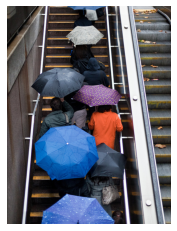

Reference captions:
people are hidden under umbrellas as they make their way up an escalator
people walking up outside stairs in raincoats under umbrellas
a group of people climbing stairs with umbrellas
many people going up some stairs with umbrellas
several people walking up some steps while holding umbrella s
Predicted caption:
a woman with a hat and a hat on a street


In [ ]:
# TO COMPLETE

lowest_cos_sim_row = stats.iloc[stats['cos_sim'].idxmin()]
lowest_cos_sim_row

# Reference captions

print('Lowest cosine similarity score =', lowest_cos_sim_row['cos_sim'])

reference_captions = stats[stats['image_id'] == lowest_cos_sim_row['image_id']]['ref'].item()
reference_captions

filename = new_file[new_file['image_id']==lowest_cos_sim_row['image_id']].iloc[0]['file_name']
generate_image(filename)

print('Reference captions:')
for caption in reference_captions:
    print(' '.join(caption))
print('Predicted caption:')
print(' '.join(lowest_cos_sim_row['pred']))

Highest cosine similarity score = 0.896855503320694


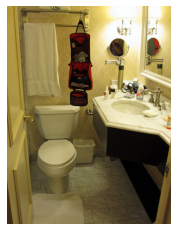

Reference captions:
a bathroom view of a tiolet and sink
a bathroom with a big mirror above the sink
a toilet a sink a towel a light and a mirror
a bathroom with white toliet and sink visible
a bathroom scene with a toilet and a sink
Predicted caption:
a bathroom with a toilet and a sink


In [ ]:
# TO COMPLETE

highest_cos_sim_row = stats.iloc[stats['cos_sim'].idxmax()]
highest_cos_sim_row

# Reference captions

reference_captions = stats[stats['image_id'] == highest_cos_sim_row['image_id']]['ref'].item()
reference_captions

print('Highest cosine similarity score =', highest_cos_sim_row['cos_sim'])

filename = new_file[new_file['image_id']==highest_cos_sim_row['image_id']].iloc[0]['file_name']
generate_image(filename)


print('Reference captions:')
for caption in reference_captions:
    print(' '.join(caption))
print('Predicted caption:')
print(' '.join(highest_cos_sim_row['pred']))

In [ ]:
stats['image_id'] = stats['image_id'].astype(int)
stats.sort_values('image_id', ascending = True)

,image_id,ref,pred,bleu,cos_sim
666,34,"[[a, zebra, grazing, on, lush, green, grass, i...","[two, zebras, are, standing, together, in, a, ...",0.137471,0.194254
512,81,"[[a, big, airplane, flying, in, the, big, blue...","[a, large, airplane, is, parked, on, the, runway]",0.073861,0.152505
419,86,"[[a, man, riding, a, motor, bike, across, a, f...","[a, man, riding, a, motorcycle, on, a, street]",0.398713,0.610569
529,127,"[[a, piece, of, cake, and, coffee, are, on, an...","[a, table, with, a, lot, of, donuts, and, a, b...",0.049269,0.432674
9,164,"[[a, small, kitchen, with, low, a, ceiling], [...","[a, kitchen, with, a, stove, and, a, table, an...",0.169436,0.546764
...,...,...,...,...,...
555,581738,"[[two, public, transit, buses, parked, in, a, ...","[a, bus, is, parked, on, a, street, next, to, ...",0.047406,0.248695
718,581857,"[[people, buying, bags, and, fruits, in, a, ma...","[a, man, is, standing, behind, a, large, pile,...",0.033032,0.366169
12,581863,"[[bathroom, with, tiled, floor, radiator, show...","[a, bathroom, with, a, toilet, and, a, sink]",0.113622,0.579749
890,581884,"[[a, crowd, of, people, flying, kites, on, a, ...","[a, group, of, people, flying, kites, on, a, b...",0.919323,0.581499


Average Cosine Similarity :  0.4386727355971125


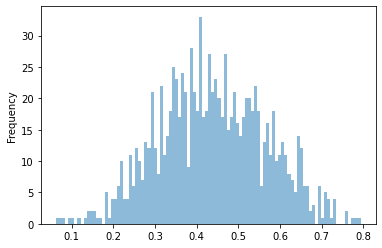

In [ ]:
print("Average Cosine Similarity : ", stats['cos_sim'].mean())
ax = stats['cos_sim'].plot.hist(bins=100, alpha=0.5)

## 7 Comparing BLEU and Cosine similarity [16 marks]

> 7.1 Test set distribution of scores (6 marks)

> 7.2 Analysis of individual examples (10 marks)

#### 7.1 Test set distribution of scores (6 marks)

Compare the model’s performance on the test set evaluated using BLEU and cosine similarity and discuss some weaknesses and strengths of each method (explain in words, in a text box below).

Please note, to compare the average test scores, you need to rescale the Cosine similarity scores [-1 to 1] to match the range of BLEU method [0.0 - 1.0].

In [ ]:
# TO COMPLETE

In [ ]:
# Rescaling cosine similarity values
stats['cos_sim'] = (stats['cos_sim']+1)/2

In [ ]:
# Average rescaled cosine similarity
print("Average Rescaled Cosine Similarity : ", stats['cos_sim'].mean())

Average Rescaled Cosine Similarity :  0.7193363677985563


In [ ]:
# Lowest rescaled cosine similarity
stats.iloc[stats['cos_sim'].idxmin()]['cos_sim']

0.5312223583459854

In [ ]:
# Highest rescaled cosine similarity
stats.iloc[stats['cos_sim'].idxmax()]['cos_sim']

0.896855503320694

In [ ]:
# Average bleu score
print("Average BLEU score:", stats['bleu'].mean())

Average BLEU score: 0.16297789643479207


Comparison of the results:

The average BLEU score of the predictions made by the model is 0.163 and the average cosine similary score after rescaling is 0.719.

Strengths of using BLEU score :

    - Widely used and is a standard for comparing performance with generated text
    - Easy to calculate, interpret and compare for different models as values ranges between 0 and 1, with a value closer to 1 being better.
    
Weaknesses of using BLEU score :

    - Only compares the machine-generated text to reference text and does not take into account the semantic and syntactic correctness of the prediction
    - Biased towards shorter predictions and can give high scores to models that produce short and incomplete predictions.
    

Strengths of using cosine similarity :

    - Can capture the semantic similarities between predicted text and reference text even if the words used in the two are different
    - Can be used on a variety of tasks like text classification and information retrieval
    
Weaknesses of using cosine similarity :

    - Might give misleading results if the sentences being compared are very short

 #### 7.2 Analysis of individual examples (10 marks)

Find and display one example where both methods give similar scores and another example where they do not and discuss. Include both scores, predicted captions, and reference captions.

In [ ]:
# TO COMPLETE

In [ ]:
sorted_stats = stats.sort_values('bleu', ascending = True)
sorted_stats.head(40)

,image_id,ref,pred,bleu,cos_sim
341,82003,"[[a, kitchen, cupboard, full, of, a, variety, ...","[a, kitchen, with, a, stove, and, a, stove, an...",0.012399,0.740257
133,475359,"[[someone, is, stuffed, in, the, black, suitca...","[a, table, with, a, table, and, a, table, with...",0.015719,0.618097
406,507939,"[[a, sink, is, filled, with, dirty, dishes, to...","[a, white, vase, with, a, white, and, white, t...",0.020200,0.632896
164,286785,"[[a, zebra, reaching, its, head, into, a, car,...","[a, black, and, white, picture, of, a, black, ...",0.020200,0.684370
932,360637,"[[there, is, a, closed, refrigerator, and, an,...","[a, kitchen, counter, with, a, stove, and, a, ...",0.021359,0.697298
476,287228,"[[a, yellow, fire, hydrant, sitting, next, to,...","[a, small, boat, is, on, the, water, with, a, ...",0.021513,0.621384
380,196944,"[[a, group, of, people, petting, a, zebra, on,...","[two, women, are, standing, near, each, other]",0.021518,0.557397
151,180357,"[[three, women, perform, a, dance, with, tradi...","[a, man, and, a, woman, are, sitting, at, a, t...",0.021973,0.610393
918,262172,"[[cardboard, boxes, piled, up, in, a, family, ...","[a, table, with, a, bunch, of, luggage, and, a...",0.021973,0.628650
848,286773,"[[two, women, with, plates, of, food, on, a, b...","[a, woman, and, a, woman, are, sitting, at, a,...",0.021973,0.649401


Case where the scores are similar:


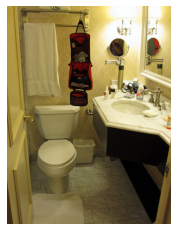

BLEU score = 1.0
Cosine similarity score = 0.8924074769020081
Reference captions:
a bathroom with a toilet sitting next to a sink
a bathroom with a sink and a mirror
a nice clean bathroom with a large sink
a clean well lit and fully stocked marble hotel bathroom
a small white bathroom with a toilet and a sink
Predicted caption:
a bathroom with a toilet and a sink


In [ ]:
similar_scores_row = stats.iloc[stats['bleu'].idxmax()]
similar_scores_row

# Reference captions

reference_captions = stats[stats['image_id'] == similar_scores_row['image_id']]['ref'].item()
reference_captions
print('Case where the scores are similar:')
generate_image(filename)

print('BLEU score =', similar_scores_row['bleu'])
print('Cosine similarity score =', similar_scores_row['cos_sim'])
print('Reference captions:')
for caption in reference_captions:
    print(' '.join(caption))
print('Predicted caption:')
print(' '.join(similar_scores_row['pred']))

Case where the scores are dissimilar:


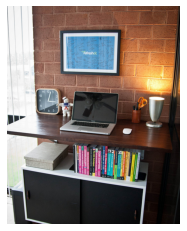

BLEU score = 0.2540663740773074
Cosine similarity score = 0.8886355757713318
Reference captions:
a laptop sitting on a desk with other accessories
a laptop on a desk in a room
a wooden shelf on a brick wall with a storage bin under it a laptop and lamp are on the shelf
a computer desk with a row of books underneath it
a computer sitting on a desk with books and a clock
Predicted caption:
a desk with a computer and a laptop on it


In [ ]:
dissimilar_scores_row = stats.loc[236]
dissimilar_scores_row

# Reference captions

reference_captions = stats[stats['image_id'] == dissimilar_scores_row['image_id']]['ref'].item()
reference_captions

print('Case where the scores are dissimilar:')
filename = new_file[new_file['image_id']==dissimilar_scores_row['image_id']].iloc[0]['file_name']
generate_image(filename)

print('BLEU score =', dissimilar_scores_row['bleu'])
print('Cosine similarity score =', dissimilar_scores_row['cos_sim'])
print('Reference captions:')
for caption in reference_captions:
    print(' '.join(caption))
print('Predicted caption:')
print(' '.join(dissimilar_scores_row['pred']))

This dissimilarity in BLEU score and cosine similarity scores can be due to how these metrics are measured.